In [1]:
from utils import make_worm, slog
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.special import softmax
plt.rcParams["animation.html"] = "jshtml"

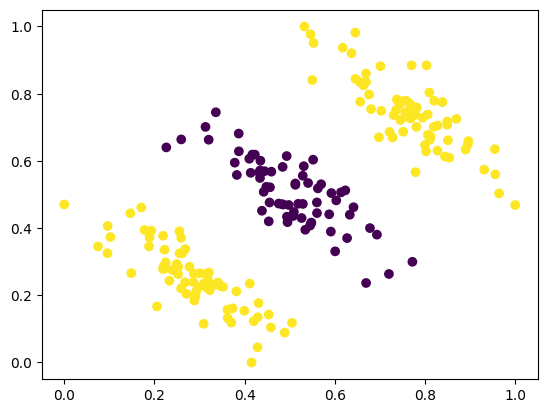

In [2]:
X,y = make_worm(D=10, T=200, sigma=0.01)
plt.scatter(X[:,0], X[:,1], c=y)

In [3]:
class eSPA_demo():

    def __init__(self,K,epsC,epsW,max_iters=200,tol=1e-8):
        self.K = K
        self.epsC=epsC
        self.epsW = epsW
        self.max_iters = max_iters
        self.tol = tol
        self._is_fitted = False

    def fit(self,X,y):

        if self._is_fitted:
            return self.fine_tune(X,y)
        
        T,D = X.shape
        
        # Convert to one-hot encoding
        self.classes = np.unique(y)
        Pi = np.zeros((T, len(self.classes)))
        for idx,c in enumerate(self.classes):
            Pi[y==c,idx]=1
        
        # Initialize C,G,W and L
        self.C = X[np.random.randint(0, T, self.K),:]
        self.G = np.zeros((T, self.K))
        self.W = np.random.rand(D) + 0.1
        self.W /= self.W.sum()
        self.L = np.random.rand(len(self.classes), self.K)


        self.hist_W = []
        self.hist_C = []
        self.hist_G = []
        self.hist_L = []
        self.hist_pred = []
        res = 50
        grid_1d = np.linspace(0, 1.0, res)

        [xx,yy] = np.meshgrid(grid_1d,grid_1d)

        X_grid = np.column_stack((yy.flatten(), xx.flatten()))

        if D>2:
            X_grid = np.hstack((X_grid, 0.5*np.ones((X_grid.shape[0],D-2))))

        self.losses = []

        for i in range(self.max_iters):

            # Update G
            self.G = cdist(X,self.C, "sqeuclidean", w=self.W) # distances between points and centroids
            self.G -= self.epsC * (np.matmul(Pi, slog(self.L)))
            mins = np.argmin(self.G, 1)
            self.G[:,:] = 0
            for m in np.unique(mins):
                self.G[mins==m,m] = 1

            # Remove empty
            emptyboxes = self.G.sum(0)==0
            if any(emptyboxes):
                self.G = self.G[:, not emptyboxes]
                self.C=self.C[not emptyboxes,:]
                self.L=self.L[:,not emptyboxes]

            # Update W
            self.W[:] = 0
            for k in range(self.K):
                self.W += np.sum(self.G[:,[k]] * ((X-self.C[[k],:])**2),0)
            self.W = softmax(-self.W/(T*self.epsW))
            
            # Update C
            self.C = (self.G.T @ X) 
            self.C /= self.G.sum(0).reshape(-1,1)

            # Update L
            self.L = Pi.T @ self.G
            sums = self.L.sum(0)
            sums[sum==0] = 1
            self.L /= sums

            # Calculate loss
            L = (self.W * ((X - self.G @ self.C)**2).sum(0)).sum() / T
            L -= (self.epsC/T) * np.sum( Pi * (slog(self.L) @ self.G.T).T)
            L += self.epsW * np.dot(self.W, slog(self.W))
            self.losses.append(L)


            self.hist_W.append(self.W.copy())
            self.hist_C.append(self.C.copy())
            self.hist_G.append(self.G.copy())
            self.hist_L.append(self.L.copy())
            self.hist_pred.append(self.predict(X_grid).T)

            if i>1 and self.losses[-2] - self.losses[-1] < 1e-8:
                break
            
        self.iterations = i

    def predict(self,X):
        G = cdist(X,self.C, "sqeuclidean", w=self.W)
        mins = np.argmin(G, 1)
        G[:,:] = 0
        for m in np.unique(mins):
            G[mins==m,m] = 1
        return self.L @ G.T


In [4]:
mod = eSPA_demo(K=3, epsC=1e-3, epsW=1e-2)
mod.fit(X,y)

In [5]:
from matplotlib.animation import FuncAnimation
frames = np.linspace(1, mod.iterations-2, mod.iterations, dtype=np.int64)
# frames = np.arange(1, 20, 1, dtype=np.int64)

mosaic="""
AB
CD
"""
fig, ax = plt.subplot_mosaic(mosaic)

stem_w = ax["A"].bar(np.arange(0,X.shape[1]),mod.hist_W[0])
ax["A"].set_ylim(0,1)
ax["A"].set_ylabel(r"$W$")
ax["A"].set_xlabel("D")
ax["A"].set_title("Feature selection")

scatter_affils = ax["B"].scatter(X[:,0], X[:,1], c=np.argmax(mod.hist_G[0],1))
ax["B"].set_xlabel(r"$x_1$")
ax["B"].set_ylabel(r"$x_2$")
ax["B"].set_ylim(0,1)
ax["B"].set_xlim(0,1)
ax["B"].set_title("Affiliations")

markov_preds = (mod.hist_L[0] @ mod.hist_G[0].T)[1,:]
scatter_affils2 = ax["C"].scatter(X[:,0], X[:,1], c=markov_preds)
scatter_centr = ax["C"].scatter(mod.hist_C[0][:,0], mod.hist_C[0][:,1], c='r', s=120)

# plt.legend(["data", "centroids"])
ax["C"].set_xlabel(r"$x_1$")
ax["C"].set_ylabel(r"$x_2$")
ax["C"].set_ylim(0,1)
ax["C"].set_xlim(0,1)
ax["C"].set_title("Predictions")

im_lambda = ax["D"].imshow(mod.hist_L[0], aspect="auto", interpolation="none")
ax["D"].set_title(r"$\Lambda$")
ax["D"].set_xlabel(r"Cluster")
ax["D"].set_ylabel(r"Class")

fig.tight_layout()

def update(i):

    # Bar plot, each bar has to be individually adjusted
    for ii in range(len(stem_w)):
        stem_w[ii].set_height(mod.hist_W[frames[i]][ii])

    # Gamma - change color only
    scatter_affils.set_array(np.argmax(mod.hist_G[i],1))

    # 
    markov_preds = (mod.hist_L[i] @ mod.hist_G[i].T)[1,:]
    scatter_affils2.set_array(markov_preds)
    scatter_centr.set_offsets(mod.hist_C[i])


    im_lambda.set_array(mod.hist_L[i])
    return stem_w, im_lambda, scatter_affils, scatter_centr

ani = FuncAnimation(
    fig, update, frames=len(frames), interval=1000
)
plt.close()
ani

In [ ]:
ani.save('eSPA.mp4')

In [6]:
from matplotlib.animation import FuncAnimation
frames = np.linspace(1, mod.iterations, mod.iterations, dtype=np.int64)

res = 50
grid_1d = np.linspace(0, 1.0, 50)
[xx,yy] = np.meshgrid(grid_1d,grid_1d)
X_grid = np.column_stack((yy.flatten(), xx.flatten()))
X_grid = np.hstack((X_grid, 0.5*np.ones((X_grid.shape[0],10-2))))


mosaic = """
BBB
BBB
BBB
AAA
"""
fig, ax = plt.subplot_mosaic(mosaic, figsize=(8,8), per_subplot_kw={"B":{"projection": "3d"}})

# Plot points
ax["B"].scatter(X[:,0],X[:,1],1-y, marker='o', s=20, c="goldenrod", alpha=0.6)
dec_bound = ax["B"].plot_surface(X_grid[:,0].reshape((res,res)), X_grid[:,1].reshape((res,res)), mod.hist_pred[0][:,0].reshape((res,res)),vmin=0.,vmax=1.)
dec_bound_proj = ax["B"].contourf(X_grid[:,0].reshape((res,res)), X_grid[:,1].reshape((res,res)), mod.hist_pred[0][:,0].reshape((res,res)), zdir='z', offset=-0.5, cmap='coolwarm',vmin=0.,vmax=1.)
ax["B"].set_xlabel(r"$x_1$")
ax["B"].set_ylabel(r"$x_2$")
ax["B"].set_zlabel("Class")

ax["B"].set(zlim=(-0.6,1))
ax["B"].view_init(elev=10., azim=20)

# Plot obj function
losses = np.array(mod.losses)
line_objs, = ax["A"].plot(0, losses[0])
ax["A"].set_ylim(0, losses.max()*1.2)
ax["A"].set_xlabel("iteration")
ax["A"].set_ylabel(r"$\mathcal{L}$")

fig.tight_layout()

def update(i):
    global dec_bound, dec_bound_proj
    # # Update obj function plot
    line_objs.set_data(frames[:i].flatten(), losses[frames[:i]])
    ax["A"].set_xlim(0, i+1)
    ax["A"].set_xticks(frames[:i].flatten(), frames[:i].flatten())
    # ax["A"].set_xticks(ax["A"].get_xticks()[1:], frames[ax["A"].get_xticks()[1:].astype(np.int64)-1])

    dec_bound.remove()
    dec_bound = ax["B"].plot_surface(X_grid[:,0].reshape((res,res)), X_grid[:,1].reshape((res,res)), mod.hist_pred[frames[i]][:,0].reshape((res,res)),cmap='viridis', vmin=0., vmax=1.)

    dec_bound_proj.remove()
    dec_bound_proj = ax["B"].contourf(X_grid[:,0].reshape((res,res)), X_grid[:,1].reshape((res,res)), mod.hist_pred[frames[i]][:,0].reshape((res,res)), zdir='z', offset=-0.5, cmap='coolwarm', vmin=0., vmax=1.)

    ax["B"].view_init(elev=10., azim=20+3*i)

    return dec_bound

ani = FuncAnimation(
    fig, update, frames=len(frames)
)
plt.close()
ani

In [ ]:
ani.save('eSPA_dec.mp4')

## Effects of hyperparameters
### K
This is pretty self-explanatory, the more K, the more discretization boxes will be used.
### $\varepsilon_W$
The value of $\varepsilon_W$ represents the "strenght" of the entropic regularization in the loss function. Interestingly, its effect is exerted in the analytical solution of the $W$ step, which looks like this:
$$W^* = \text{softmax}(-\frac{1}{T \varepsilon_W} b)$$
where $b$ are the errors in each dimension, summed over $T$.
Thus, $\varepsilon_W$ acts as the temperature of the softmax function. Let us have a closer look in the following example

Text(0, 0.5, 'dimension')

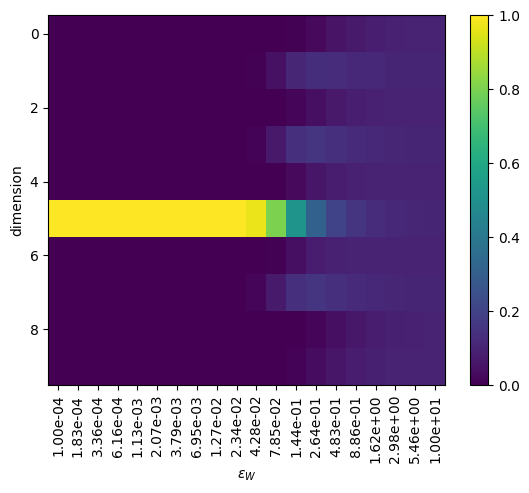

In [7]:
# Create a random vector
x = np.random.rand(10)

# Select some temperatures
Ts = np.logspace(-4, 1, 20)

x_softmax = np.zeros((x.shape[0], len(Ts)))
for idx,t in enumerate(Ts):
    x_softmax[:,idx] = softmax(x/t)

# plt.contourf(Ts, np.arange(10), x_softmax)
plt.imshow(x_softmax, aspect='auto', interpolation='none')
plt.colorbar()
plt.xlabel(r"$\varepsilon_W$")
plt.xticks(np.arange(len(Ts)), ["%.2e" %t for t in Ts], rotation=90)
plt.ylabel("dimension")

Note how increasing the temperature (i.e., $\varepsilon_W$) we obtain progressively more maximum entropy vectors, and viceversa by decreasing the temperature we obtain minimum entropy vectors.

The same applies to $W$, by changing epsilon we can control the entropy of $W$, and thus the strenght of the dimensionality reduction.

## $\varepsilon_{CL}$
This paramters influences the strength of the classification problem in the general optimization problem. Note that it affects the solution of $\Gamma$ step. In fact, if $\varepsilon_{C} \rightarrow 0$, we will have the same solution as k-means, whereas if $\varepsilon_C \rightarrow \infty$ the actual distance between the points and the centroids will play less role in the affiliation process than their labels.

As an example, let us consider some blobs

In [8]:
from sklearn.datasets import make_blobs
centroids = np.array([[.8,.8], [.2,.2], [.2,.8]])
X_example, y_example = make_blobs(n_samples=100, n_features=2,centers=centroids, cluster_std=[.1,.1,.2])

pi = np.zeros((100,2))
pi[y_example!=1,0] = 1
pi[y_example==1,1] = 1 

L = np.array([[1,0,0.5],[0,1,0.5]])

In the plots below you can see:
- The data and their labels. Overimposed are the centroids, and they are colored accorgin to the $\Lambda$.
- The distance used for k-means affiliation to the upper-left cluster. This is the squared euclidean distance and does not take labels into account.
- The distance used in the $\Gamma$ step, with very small $\varepsilon_C$. It is not too far from the previous plot
- The distance used in the $\Gamma$ step, with larger $\varepsilon_C$. This contribution modifies the distance depending on the labels. It can be seen that the points belonging to the lower centroids are now "further" from the upper left, while the ones on the right cluster are "closer" as they share the same label.

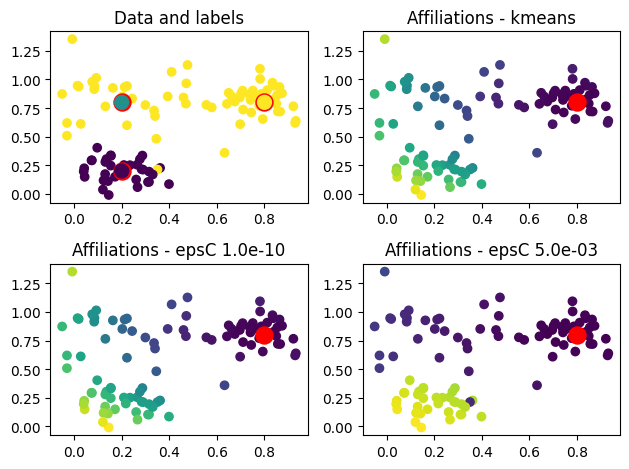

In [9]:
epsC1, epsC2=1e-10, 5e-3
G_kmeans = cdist(X_example,centroids, "sqeuclidean") # distances between points and centroids
G_kmeans_and_labels_1 = G_kmeans - epsC1 * (np.matmul(pi, slog(L)))
G_kmeans_and_labels_2 = G_kmeans - epsC2 * (np.matmul(pi, slog(L)))


fig, axs = plt.subplots(2,2)

axs[0,0].scatter(X_example[:,0], X_example[:,1], c=pi[:,0])
axs[0,0].scatter(centroids[:,0], centroids[:,1], s=150, c='r')
axs[0,0].scatter(centroids[:,0], centroids[:,1], s=100, c=L[0,:])
axs[0,0].set_title('Data and labels')


# axs[0,1].scatter(X_example[:,0], X_example[:,1], c=np.argmin(G_kmeans,1))
axs[0,1].scatter(X_example[:,0], X_example[:,1], c=G_kmeans[:,0])
axs[0,1].scatter(centroids[0,0], centroids[0,1], s=150, c='r')

axs[0,1].set_title('Affiliations - kmeans')

# axs[1,0].scatter(X_example[:,0], X_example[:,1], c=np.argmin(G_kmeans_and_labels_1,1))
axs[1,0].scatter(X_example[:,0], X_example[:,1], c=G_kmeans_and_labels_1[:,0])
axs[1,0].scatter(centroids[0,0], centroids[0,1], s=150, c='r')

axs[1,0].set_title('Affiliations - epsC %.1e' % epsC1)

# axs[1,1].scatter(X_example[:,0], X_example[:,1], c=np.argmin(G_kmeans_and_labels_2,1))
axs[1,1].scatter(X_example[:,0], X_example[:,1], c=G_kmeans_and_labels_2[:,0])
axs[1,1].scatter(centroids[0,0], centroids[0,1], s=150, c='r')

axs[1,1].set_title('Affiliations - epsC %.1e' % epsC2)

fig.tight_layout()

See below the effect of this. Since our $\Lambda$ is flat for the upper-left cluster, increasing #\varepsilon_C$ changes the affiliation of some datapoints depending on their class. 

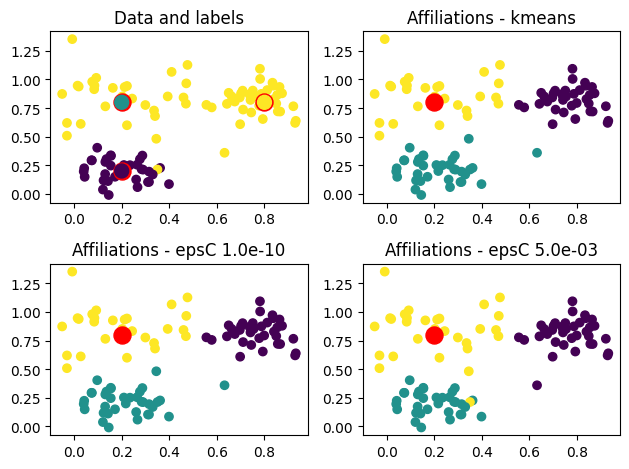

In [10]:
fig, axs = plt.subplots(2,2)

axs[0,0].scatter(X_example[:,0], X_example[:,1], c=pi[:,0])
axs[0,0].scatter(centroids[:,0], centroids[:,1], s=150, c='r')
axs[0,0].scatter(centroids[:,0], centroids[:,1], s=100, c=L[0,:])
axs[0,0].set_title('Data and labels')


axs[0,1].scatter(X_example[:,0], X_example[:,1], c=np.argmin(G_kmeans,1))
axs[0,1].scatter(centroids[2,0], centroids[2,1], s=150, c='r')

axs[0,1].set_title('Affiliations - kmeans')

axs[1,0].scatter(X_example[:,0], X_example[:,1], c=np.argmin(G_kmeans_and_labels_1,1))
axs[1,0].scatter(centroids[2,0], centroids[2,1], s=150, c='r')

axs[1,0].set_title('Affiliations - epsC %.1e' % epsC1)

axs[1,1].scatter(X_example[:,0], X_example[:,1], c=np.argmin(G_kmeans_and_labels_2,1))
axs[1,1].scatter(centroids[2,0], centroids[2,1], s=150, c='r')

axs[1,1].set_title('Affiliations - epsC %.1e' % epsC2)

fig.tight_layout()